In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler
#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform
# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

In [3]:
df = pd.read_csv("../../../our_analyses/dataset_prepared.csv")

In [4]:
df['explicit'] = df['explicit'].apply(lambda x: 1 if x else 0)
df['genre'] = pd.factorize(df['genre'])[0]
y = np.array(df["genre"])
df = df.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
X = df.values

In [5]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_minmax)

In [7]:
def get_linkage_matrix(model):
    # Create linkage matrix 
    
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    linkage_matrix = get_linkage_matrix(model)
    dendrogram(linkage_matrix, **kwargs)

### FInd the best number of cluster

In [8]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

silhouette_scores = []
for k in range(2, 11):  # Prova con un numero di cluster da 2 a 10
    model = AgglomerativeClustering(n_clusters=k, linkage='average')
    labels = model.fit_predict(X_pca)
    silhouette_avg = silhouette_score(X_pca, labels)
    silhouette_scores.append(silhouette_avg)

# Trova il numero ottimale di cluster
optimal_k = silhouette_scores.index(max(silhouette_scores)) + 2
print("Numero ottimale di cluster:", optimal_k)

# Ora puoi creare il modello con il numero ottimale di cluster
model = AgglomerativeClustering(n_clusters=optimal_k, linkage='average')


Numero ottimale di cluster: 3


### Find the best distance threshold

In [9]:
# Range di valori per testare il distance_threshold
threshold_range = np.linspace(start=0.1, stop=1.2, num=20)

best_silhouette = -1
best_threshold = None

for threshold in threshold_range:
    model = AgglomerativeClustering(distance_threshold=threshold, n_clusters=None, metric="cosine", linkage='average')
    model = model.fit(X_pca)
    labels = model.labels_
    if len(set(labels)) > 1:  # Assicurati che ci siano almeno 2 cluster
        silhouette_avg = silhouette_score(X_pca, labels)
        print("Threshold:", threshold, "Silhouette:", silhouette_avg)
        if silhouette_avg > best_silhouette:
            best_silhouette = silhouette_avg
            best_threshold = threshold

print("Miglior distance_threshold:", best_threshold, "con silhouette di:", best_silhouette)


Threshold: 0.1 Silhouette: 0.1329514365483403
Threshold: 0.15789473684210525 Silhouette: 0.1494099781416061
Threshold: 0.21578947368421053 Silhouette: 0.1557954808254818
Threshold: 0.27368421052631575 Silhouette: 0.18443492133653022
Threshold: 0.33157894736842103 Silhouette: 0.19791062811942842
Threshold: 0.3894736842105263 Silhouette: 0.2414217136175037
Threshold: 0.4473684210526315 Silhouette: 0.23445639004632673
Threshold: 0.5052631578947367 Silhouette: 0.23016317932310423
Threshold: 0.5631578947368421 Silhouette: 0.23016317932310423
Threshold: 0.6210526315789473 Silhouette: 0.23016317932310423
Threshold: 0.6789473684210525 Silhouette: 0.2586148596564873
Threshold: 0.7368421052631577 Silhouette: 0.24476204160977147
Threshold: 0.7947368421052631 Silhouette: 0.24476204160977147
Threshold: 0.8526315789473683 Silhouette: 0.31066331980002687
Threshold: 0.9105263157894735 Silhouette: 0.31066331980002687
Threshold: 0.9684210526315788 Silhouette: 0.31066331980002687
Threshold: 1.02631578947

### Try firstly with no specific values

The dendrogram with average linkage using the cosine distance metric presents a hierarchical structure where clusters are merged based on the average distance between all pairs of objects in any two clusters. In this dendrogram, we can see that there is a significant merger (the blue line) that combines two large groups of data points, suggesting a major division in the data. The height of the merge point indicates the distance at which clusters are combined, with lower heights suggesting closer or more similar groups.

This dendrogram also shows several smaller clusters (indicated by the lower height of the orange and green lines) that merge at different levels of similarity. These clusters are relatively compact, which suggests that the elements within each cluster are similar to each other according to the cosine distance.

In choosing the number of clusters to cut the dendrogram, we would look for large jumps in merge height, which are indicative of the combination of distinct groups into a single cluster. This can be seen in the significant height difference between the last merge and the previous ones.

The choice of using cosine distance is particularly appropriate for datasets where the shape of the data distributions is important but not their magnitude. This is often the case in text analysis or gene expression data where the direction of the vectors is more important than their length.

Overall, this dendrogram suggests that there is a clear hierarchical structure within the data. However, whether this is the best representation depends on the context of the data and the specific research questions at hand. It would be useful to compare this dendrogram to those created with other linkage methods and distance metrics to determine which best captures the nuances of the dataset.

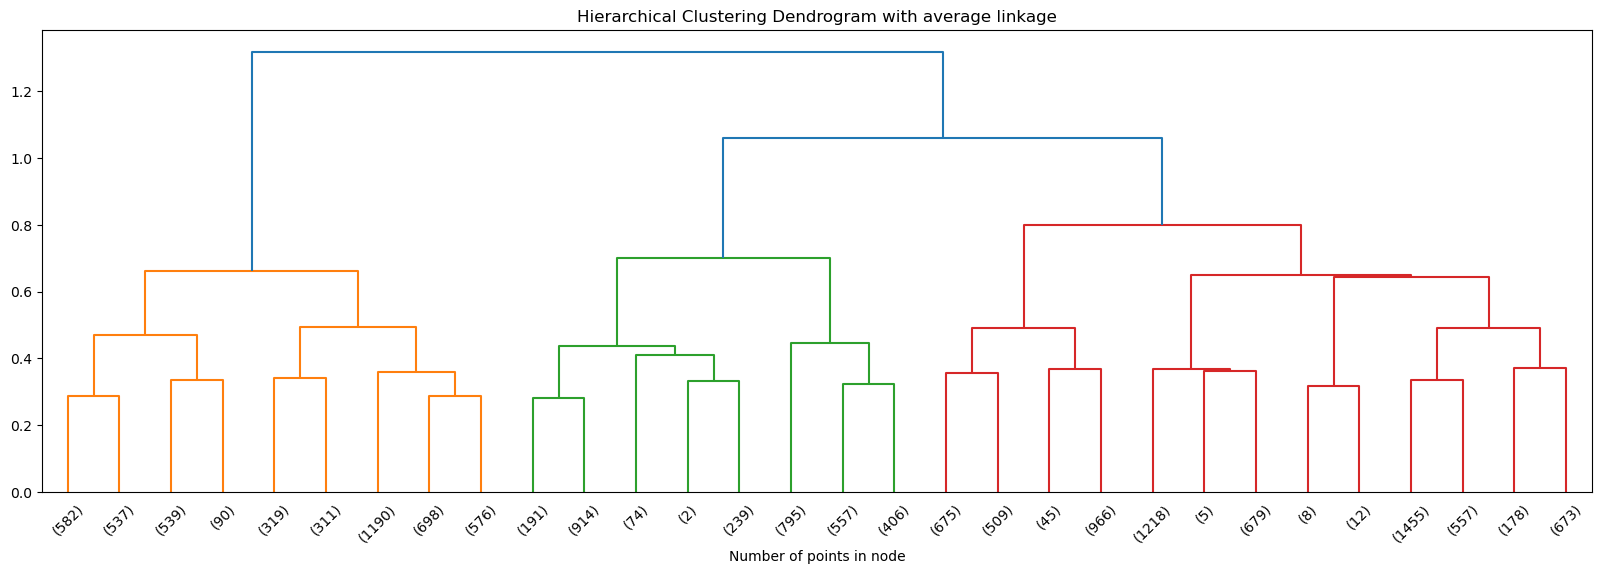

In [17]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, 
                                metric='cosine', linkage='average')
model = model.fit(X_pca)

plt.figure(figsize=(20, 6))
plt.title("Hierarchical Clustering Dendrogram with average linkage")
plot_dendrogram(model, truncate_mode='lastp')
plt.xlabel("Number of points in node")
plt.show()

### Calculate Silhoutte

In [14]:
Z = get_linkage_matrix(model)
labels = fcluster(Z, t=  1.0842105263157893, criterion='distance')

print('Silhouette', silhouette_score(X_pca, labels))

Silhouette 0.3329924533762927


### Choosing the number of clusters

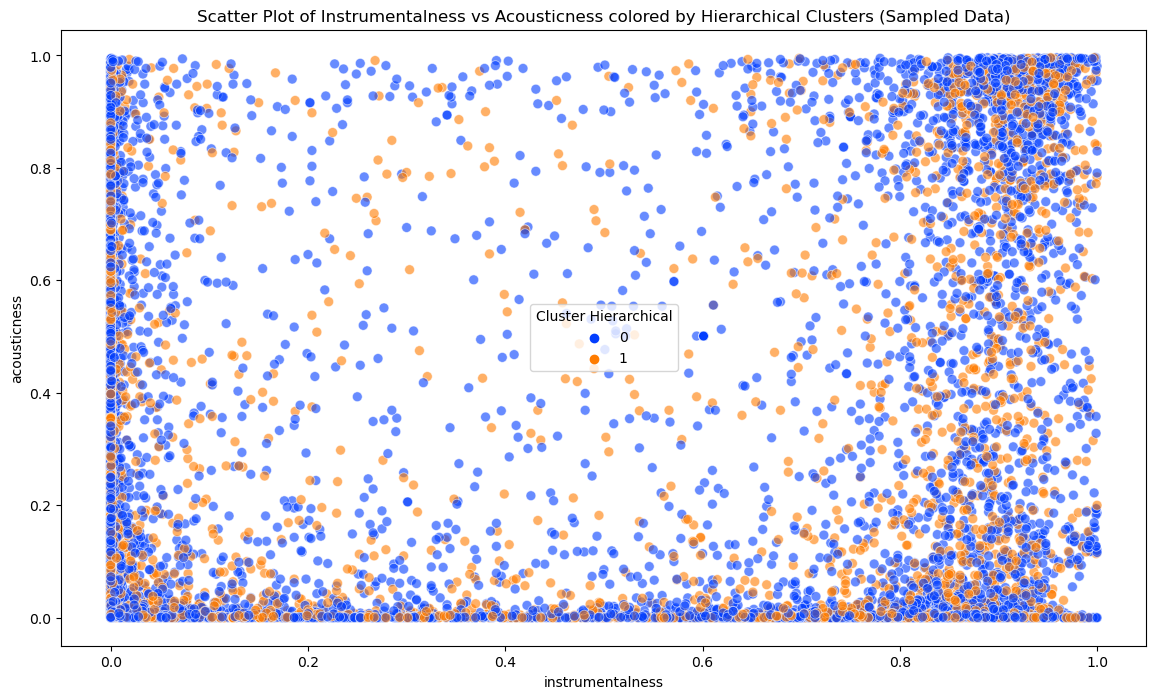

(array([0, 1]), array([10158,  4842]))

In [15]:
hier = AgglomerativeClustering(distance_threshold=1.0842105263157893, n_clusters=None, metric="cosine", linkage='average')
hier.fit(X_pca)

# Assegniamo i label del clustering gerarchico al dataframe
df['hier_labels'] = hier.labels_

# Troviamo i cluster unici e la loro frequenza per determinare i centroidi
unique_hier_labels, counts_hier_labels = np.unique(hier.labels_, return_counts=True)

# Creiamo il grafico scatterplot per i dati campionati
plt.figure(figsize=(14, 8))
scatter_plot_hier = sns.scatterplot(data=df, 
                                    x="instrumentalness",
                                    y="acousticness", 
                                    hue='hier_labels', 
                                    palette="bright",
                                    alpha=0.6,  # Impostiamo una trasparenza
                                    s=50)  # Dimensione dei punti

# Aggiungiamo legenda e titolo
plt.legend(title='Cluster Hierarchical')
plt.title('Scatter Plot of Instrumentalness vs Acousticness colored by Hierarchical Clusters (Sampled Data)')
plt.show()

# Stampiamo i cluster unici e il loro conteggio per confermare
unique_hier_labels, counts_hier_labels

In [13]:
# Riproviamo con parametri che dovrebbero richiedere meno tempo di computazione
kmeans_quick = AgglomerativeClustering(distance_threshold=  1.0842105263157893, n_clusters=None, metric="cosine", linkage='average')
kmeans_quick.fit(X_pca)

# Estraiamo nuovamente i centroidi dei cluster
centers_quick = kmeans_quick.cluster_centers_

# Verifichiamo il numero di cluster unici e il numero di centroidi
unique_labels_quick = np.unique(kmeans_quick.labels_)
unique_labels_quick, centers_quick.shape[0]

# Scatter Plot dei Cluster corretto
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_quick.labels_, cmap='viridis')
plt.scatter(centers_quick[:, 0], centers_quick[:, 1], c='red', marker='*', s=200)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Aggiungiamo una legenda per i centroidi
for i, c in enumerate(centers_quick):
    plt.text(c[0], c[1], f'    {i+1}', color='red')

# Mostra il grafico
plt.show()

AttributeError: 'AgglomerativeClustering' object has no attribute 'cluster_centers_'

In [ ]:
# Riproviamo con parametri che dovrebbero richiedere meno tempo di computazione
kmeans_quick = KMeans(n_clusters=5, n_init=1, max_iter=10, random_state=4)
kmeans_quick.fit(X_pca)

# Estraiamo nuovamente i centroidi dei cluster
centers_quick = kmeans_quick.cluster_centers_

# Verifichiamo il numero di cluster unici e il numero di centroidi
unique_labels_quick = np.unique(kmeans_quick.labels_)
unique_labels_quick, centers_quick.shape[0]

# Scatter Plot dei Cluster corretto
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_quick.labels_, cmap='viridis')
plt.scatter(centers_quick[:, 0], centers_quick[:, 1], c='red', marker='*', s=200)
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')

# Aggiungiamo una legenda per i centroidi
for i, c in enumerate(centers_quick):
    plt.text(c[0], c[1], f'    {i+1}', color='red')

# Mostra il grafico
plt.show()

: 

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances
import numpy as np

# Supponiamo che X_pca sia il tuo set di dati ridotto in dimensioni

# Inizializza e adatta AgglomerativeClustering
hier = AgglomerativeClustering(distance_threshold=0.4473684210526315, n_clusters=None, metric="cosine", linkage='average')
hier.fit(X_pca)

# Ottieni le etichette del cluster
labels = hier.labels_

# Crea la matrice di somiglianza
similarity_matrix = np.zeros((len(labels), len(labels)))
for i in range(len(labels)):
    for j in range(len(labels)):
        if labels[i] == labels[j]:
            similarity_matrix[i, j] = 1

# Calcola la matrice di distanza
distance_matrix = pairwise_distances(X_pca, metric="cosine")

# Converti la matrice di distanza in una matrice di somiglianza (in modo che i valori più alti indicano maggiore vicinanza)
max_distance = np.max(distance_matrix)
similarity_matrix_from_distance = 1 - (distance_matrix / max_distance)

# Calcola la correlazione
# Trasforma le matrici in vettori unidimensionali
upper_triangle_indices = np.triu_indices_from(similarity_matrix, k=1)
similarity_vector = similarity_matrix[upper_triangle_indices]
distance_vector = similarity_matrix_from_distance[upper_triangle_indices]

# Calcola la correlazione di Pearson
correlation = np.corrcoef(similarity_vector, distance_vector)[0, 1]

print(f"Correlazione tra la matrice di somiglianza dei cluster e la matrice di distanza: {correlation}")


: 

### connectivity in Clustering Gerarchico
Nel contesto del clustering gerarchico, connectivity è una matrice che definisce la struttura dei dati o il modo in cui i punti dati sono connessi tra loro. Questa connettività può influenzare come i cluster vengono formati durante l'algoritmo di clustering.

kneighbors_graph: Questa funzione costruisce una matrice di connettività basata sui k vicini più prossimi di ciascun punto. In questo caso, n_neighbors=100 significa che per ogni punto dati, stai considerando i suoi 100 vicini più prossimi per definire la connettività.

include_self=False: Indica che il punto stesso non dovrebbe essere incluso nei suoi vicini più prossimi.

Utilizzare una matrice di connettività nel clustering gerarchico è utile per considerare solo certe relazioni tra i punti, ad esempio per imporre una struttura di vicinato o per lavorare con dati che hanno una struttura di rete o grafica intrinseca.

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Esegui l'Hierarchical Clustering
model = AgglomerativeClustering(distance_threshold=  0.4473684210526315, n_clusters=None, metric="cosine", linkage='average')
model = model.fit(X_pca)

# Assegna le etichette dei cluster dal modello di Hierarchical Clustering
hierarchical_cluster_labels = model.labels_

# Crea una nuova colonna nel DataFrame per i cluster
df['cluster'] = hierarchical_cluster_labels

# Dato che 'genre' è stato rimosso da df e salvato in y, aggiungiamo 'genre' di nuovo a df
df['genre'] = y

# Calcolare la frequenza di ogni genere in ciascun cluster
cluster_genre_counts = df.groupby(['cluster', 'genre']).size().unstack(fill_value=0)

# Calcolare la dimensione di ogni cluster
cluster_sizes = df['cluster'].value_counts()

# Calcolare le proporzioni relative di ogni genere all'interno dei cluster
cluster_genre_proportions = cluster_genre_counts.div(cluster_sizes, axis=0)

# Determinare il cluster dominante per ogni genere basandosi sulle proporzioni
dominant_cluster_per_genre = cluster_genre_proportions.idxmax(axis=0)

print(dominant_cluster_per_genre)


: 